In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Definir os caminhos para as pastas de treino e teste
caminho_base = 'SOUVIK/'
caminho_treino = caminho_base + 'train/'
caminho_teste = caminho_base + 'test/'


In [ ]:

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# 1. Gerador para os dados de TREINO com Data Augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,             # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=45,          # Rotaciona a imagem aleatoriamente em até 45 graus
    width_shift_range=0.2,      # Desloca a imagem na horizontal
    height_shift_range=0.2,     # Desloca a imagem na vertical
    shear_range=0.2,            # Aplica distorções (cisalhamento)
    zoom_range=0.2,             # Aplica zoom aleatório
    horizontal_flip=True,       # Inverte a imagem horizontalmente
    fill_mode='nearest'
)



In [4]:
# 2. Gerador para os dados de TESTE (APENAS normalização)
test_image_generator = ImageDataGenerator(rescale=1./255)

# 3. Carregar as imagens dos diretórios usando os geradores
train_data_gen = train_image_generator.flow_from_directory(
    directory=caminho_treino,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary' # Porque temos duas classes (plastic, no-plastic)
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=caminho_teste,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 1720 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


Por que ImageDataGenerator?

Automação: Ele identifica automaticamente as classes (plastic e no-plastic) a partir dos nomes das subpastas. Ele atribui o rótulo 0 para uma classe e 1 para a outra.

Eficiência de Memória: Em vez de carregar todas as imagens na memória RAM (o que seria inviável para grandes datasets), ele carrega apenas um "lote" (batch) de imagens por vez.

O que é rescale=1./255?

As imagens têm pixels que variam de 0 a 255. As redes neurais funcionam muito melhor com valores pequenos, geralmente entre 0 e 1. Essa operação simplesmente divide o valor de cada pixel por 255, normalizando os dados.

O que é Data Augmentation?

É uma técnica para "criar" novas imagens de treino a partir das existentes, aplicando transformações aleatórias (rotação, zoom, inversão, etc.).

Por que usar? Isso torna nosso modelo mais robusto e ajuda a evitar o overfitting (quando o modelo decora os dados de treino em vez de aprender a generalizar).

Importante: Nós SÓ aplicamos Data Augmentation nos dados de treino. Os dados de teste devem permanecer intactos para que possamos avaliar o modelo em exemplos "reais" e não vistos.

O que é flow_from_directory?

É o método que conecta nosso gerador à estrutura de pastas.

target_size: Redimensiona todas as imagens para um tamanho padrão (150x150 pixels). Isso é obrigatório, pois a rede neural precisa de entradas com dimensões fixas.

batch_size: Define quantas imagens serão passadas pela rede de uma só vez.

class_mode='binary': Informa que se trata de uma classificação binária (duas classes). Se tivéssemos mais de duas classes, usaríamos 'categorical'.

Passo 3: Construção do Modelo (Arquitetura da CNN)
Agora vamos montar a nossa rede, camada por camada. Uma arquitetura comum para CNNs é empilhar camadas Conv2D e MaxPooling2D.

In [5]:
modelo = Sequential([
    # 1º Bloco Convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # 2º Bloco Convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 3º Bloco Convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada de achatamento para conectar com as camadas densas
    Flatten(),

    # Camada Densa (Totalmente Conectada)
    Dense(512, activation='relu'),
    
    # Camada de Dropout para regularização
    Dropout(0.5),

    # Camada de Saída
    Dense(1, activation='sigmoid')
])

# Visualizar a arquitetura do modelo
modelo.summary()

c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Conv2D(filtros, tamanho_do_kernel, activation, input_shape): A camada mais importante da CNN.

O que faz? Ela age como uma "lanterna" que varre a imagem procurando por padrões (bordas, texturas, formas). Cada filtro aprende a detectar um padrão específico.

32, 64, 128: É o número de filtros (ou padrões) que a camada vai aprender. Começamos com menos e aumentamos a profundidade para aprender padrões mais complexos.

(3, 3): É o tamanho da "lanterna" (kernel).

activation='relu': Uma função de ativação que introduz não-linearidade, permitindo que a rede aprenda relações mais complexas. ReLU é a mais comum.

input_shape: Só é necessário na primeira camada para dizer ao modelo o formato da entrada (imagem 150x150 com 3 canais de cor RGB).

MaxPooling2D(pool_size):

O que faz? Reduz o tamanho dos mapas de características (a saída da camada Conv2D), mantendo as informações mais importantes. Isso torna o modelo mais rápido e mais resistente a pequenas variações na posição dos objetos na imagem.

Flatten():

O que faz? A saída dos blocos convolucionais é uma matriz 3D. Essa camada "achata" essa matriz, transformando-a em um vetor 1D. Isso é necessário para conectar as camadas convolucionais às camadas densas.

Dense(unidades, activation):

O que faz? É a camada "clássica" de uma rede neural. Cada neurônio nela está conectado a todos os neurônios da camada anterior. É aqui que a classificação final acontece, com base nos padrões extraídos pelas camadas convolucionais.

512: Número de neurônios na camada.

Dropout(taxa):

O que faz? Durante o treinamento, "desliga" aleatoriamente uma porcentagem de neurônios (aqui, 50%). É uma técnica de regularização muito eficaz para previnir overfitting.

Camada de Saída: Dense(1, activation='sigmoid')

1: Apenas um neurônio na saída, pois a resposta é binária (é plástico ou não é?).

activation='sigmoid': Essa função espreme a saída para um valor entre 0 e 1, que pode ser interpretado como a probabilidade da imagem pertencer à classe "1" (por exemplo, "plastic"). Se o valor for > 0.5, classificamos como plástico; se for < 0.5, como não-plástico.

In [6]:
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

optimizer='adam': O otimizador é o algoritmo que ajusta os pesos internos da rede para minimizar a perda. Adam é um otimizador muito popular e eficiente, sendo uma ótima escolha padrão.

loss='binary_crossentropy': A função de perda (ou "função de custo") mede o quão errado o modelo está. Como temos uma classificação binária (0 ou 1) e uma saída sigmoid, binary_crossentropy é a função de perda matematicamente correta para este problema.

metrics=['accuracy']: A métrica que queremos observar durante o treinamento. A acurácia nos diz a porcentagem de imagens que o modelo classificou corretamente.

In [8]:
# Definir o número de épocas
EPOCHS = 20

# Calcular o número de passos por época
# Total de amostras / Tamanho do lote
steps_per_epoch = train_data_gen.samples // BATCH_SIZE
validation_steps = test_data_gen.samples // BATCH_SIZE

# Treinar o modelo
history = modelo.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=test_data_gen,
    validation_steps=validation_steps
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6013 - loss: 0.9048

c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 860ms/step - accuracy: 0.6896 - loss: 0.6391 - val_accuracy: 0.7115 - val_loss: 0.5748
Epoch 2/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.8125 - loss: 0.3833

c:\Users\jambi\OneDrive\Documentos\repositorios-git\sptech\TCC\machine-learning\cnn-v3\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.8125 - loss: 0.3833 - val_accuracy: 0.7236 - val_loss: 0.5839
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 821ms/step - accuracy: 0.7885 - loss: 0.4474 - val_accuracy: 0.7260 - val_loss: 0.6069
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8438 - loss: 0.4397 - val_accuracy: 0.7188 - val_loss: 0.5820
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 787ms/step - accuracy: 0.8246 - loss: 0.3881 - val_accuracy: 0.7163 - val_loss: 0.5887
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.8438 - loss: 0.3155 - val_accuracy: 0.7188 - val_loss: 0.5911
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 838ms/step - accuracy: 0.8436 - loss: 0.3421 - val_accuracy: 0.7212 - val_loss: 0.6136
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9688 - loss: 0.1854 - val_accuracy: 0.7308 - val_loss: 0.6054
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 819ms/step - accuracy: 0.8430 - loss: 0.3481 - val_accuracy: 0.6587 -

modelo.fit(): É a função que inicia o processo de treinamento.

epochs (Épocas): Uma época significa que o modelo viu e aprendeu com todas as imagens do conjunto de treino uma vez. Treinar por 20 épocas significa que o modelo passará pelo dataset completo 20 vezes.

steps_per_epoch: O número de lotes (batches) de dados de treino que o modelo verá em uma época.

validation_data: Os dados que usamos para verificar se o modelo está generalizando bem para dados que ele nunca viu antes.

validation_steps: Similar ao steps_per_epoch, mas para os dados de validação.

history: O método fit() retorna um objeto que contém um registro da perda e da acurácia em cada época, tanto para os dados de treino quanto para os de validação. Vamos usar isso no próximo passo.

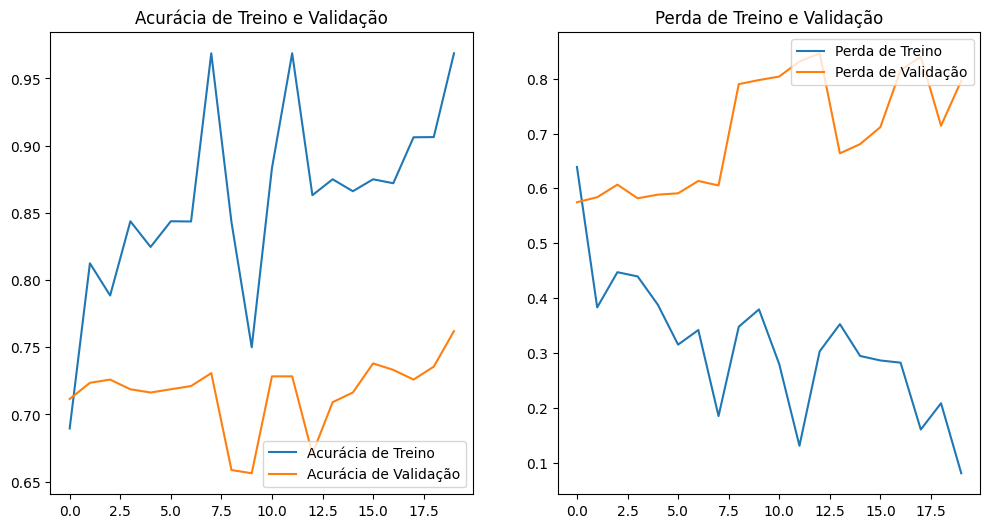

In [9]:
# Pegar os resultados do histórico de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Criar gráficos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()

In [ ]:


from tensorflow.keras.preprocessing import image

# Carregar a imagem
caminho_imagem = 'trash6.png'
img = image.load_img(caminho_imagem, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Converter a imagem para um array numpy
img_array = image.img_to_array(img)

# Expandir as dimensões para corresponder ao formato de entrada do modelo (lote de 1)
img_batch = np.expand_dims(img_array, axis=0)

# Normalizar a imagem
img_preprocessed = img_batch / 255.0

# Fazer a previsão
prediction = modelo.predict(img_preprocessed)

# Interpretar o resultado
print(f"Probabilidade Bruta: {prediction[0][0]}")

if prediction[0][0] > 0.5:
    print("Previsão: Plástico")
else:
    print("Previsão: Não-Plástico")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probabilidade Bruta: 0.9795615077018738
Previsão: Plástico
